![alt text](CDC-Zombies.jpg "Title")

In [54]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import starsim as ss
from zombie import Zombie, DeathZombies, KillZombies, zombie_vaccine
import sciris as sc
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

pyplot.rcParams['figure.dpi'] = 90

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (0.02 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.19 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.31 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.33 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.34 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.36 s)  •••••••••••••••••••• 100%



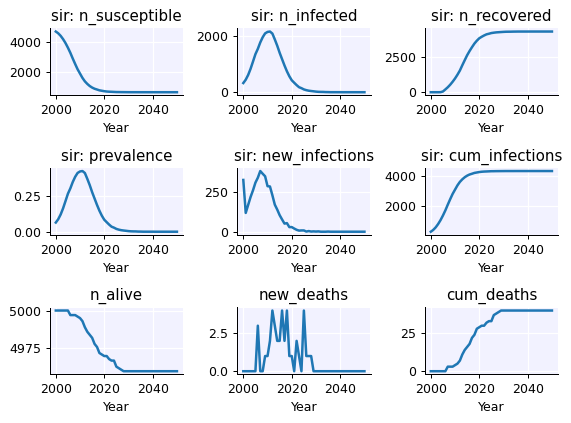

In [55]:
people = ss.People(n_agents=5_000)
sir = ss.SIR(init_prev=0.05, beta=0.1)
network = ss.RandomNet(n_contacts=ss.poisson(lam=4))
sim = ss.Sim(people=people, diseases=sir, networks=network)
sim.run()
sim.plot();

Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (0.01 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.16 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.36 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.39 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.41 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.42 s)  •••••••••••••••••••• 100%



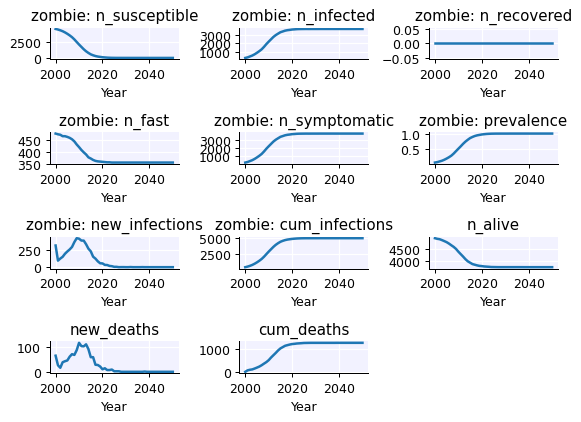

In [56]:
people = ss.People(n_agents=5_000)
zombie = Zombie(init_prev=0.05, beta=0.1)
network = ss.RandomNet(n_contacts=ss.poisson(lam=4))

sim = ss.Sim(people=people, diseases=zombie, networks=network)
sim.run()
sim.plot();

Initializing sim with 5000 agents
  Running 2024.0 ( 0/33) (0.02 s)  ———————————————————— 3%
  Running 2029.0 (10/33) (0.13 s)  ••••••—————————————— 33%
  Running 2034.0 (20/33) (0.35 s)  ••••••••••••———————— 64%
  Running 2039.0 (30/33) (0.59 s)  ••••••••••••••••••—— 94%


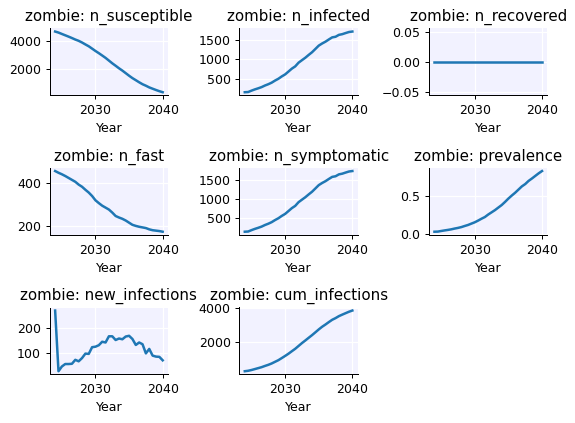

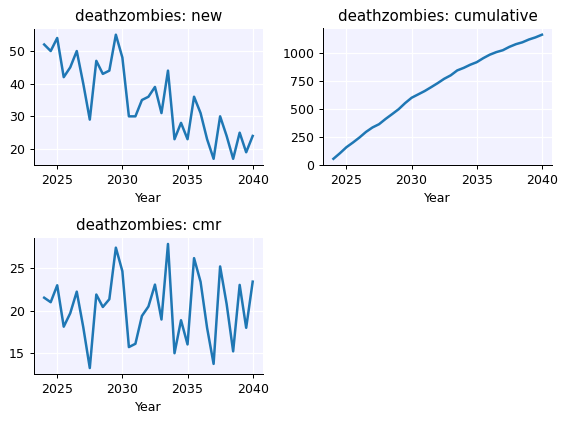

In [57]:
people = ss.People(n_agents=5_000)

zombie_pars = dict(
    init_prev = 0.05,
    beta = 0.1,
    p_fast = ss.bernoulli(p=0.10),
    p_death_on_zombie_infection = ss.bernoulli(p=0.5),
    p_symptomatic = ss.bernoulli(p=1.0),
)
zombie = Zombie(zombie_pars)

def choose_degree(self, sim, uids):
    mean_degree = np.full(fill_value=4, shape=len(uids))
    zombie = sim.diseases['zombie']
    mean_degree[zombie.fast] = 10
    return mean_degree

network = ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree))

death_pars = dict(
    death_rate=20,
    p_zombie_on_natural_death=ss.bernoulli(p=0),
)
demog = DeathZombies(**death_pars)

sim_pars = dict(start=2024, end=2040, dt=0.5)
sim = ss.Sim(sim_pars, people=people, diseases=zombie, networks=network, demographics=demog)
sim.run()
sim.plot('zombie')
sim.plot('deathzombies');

In [58]:
scens = {
    'DefaultAssumptions': {},
    '75% Fast Zombies': {'zombie_pars': dict(p_fast=0.75)},
    '25% Asymptomatic Zombies': {'zombie_pars': dict(p_symptomatic=0.25)},
    '10% Death on Zombie Infection': {'zombie_pars': dict(p_death_on_zombie_infection=ss.bernoulli(p=0.10))},
    '75% Zombie on Natural Death': {'death_pars': dict(p_zombie_on_natural_death=ss.bernoulli(p=0.75))},
}

In [59]:
def run_zombies(scen, rand_seed, zombie_pars=None, death_pars=None, intvs=[], **kwargs):
    people = ss.People(n_agents=5_000)

    zombie_pars = sc.mergedicts(dict(
        init_prev = 0.05,
        beta = 0.1,
        p_fast = ss.bernoulli(p=0.10),
        p_death_on_zombie_infection = ss.bernoulli(p=0.5),
        p_symptomatic = ss.bernoulli(p=1.0),
    ), zombie_pars)
    zombie = Zombie(zombie_pars)

    def choose_degree(self, sim, uids):
        mean_degree = np.full(fill_value=4, shape=len(uids))
        zombie = sim.diseases['zombie']
        mean_degree[zombie.fast] = 10
        return mean_degree

    network = ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree))

    death_pars = sc.mergedicts(dict(
        death_rate=20,
        p_zombie_on_natural_death=ss.bernoulli(p=0),
    ), death_pars)
    demog = DeathZombies(**death_pars)

    interventions = KillZombies(year=2024, rate=0.5)
    interventions = [interventions] + sc.promotetolist(intvs) # Add interventions passed in

    sim_pars = dict(start=2024, end=2040, dt=0.5, rand_seed=rand_seed, label=scen, verbose=0)
    sim = ss.Sim(sim_pars, people=people, diseases=zombie, networks=network, demographics=demog, interventions=intvs)
    sim.run()

    # Package results
    df = pd.DataFrame( {
        'Year': sim.yearvec,
        'Zombie Prevalence': sim.results.zombie.prevalence,
        'Deaths': sim.results.deathzombies.cumulative,
    })
    df['rand_seed'] = rand_seed
    df['Scen'] = scen
    for key, val in kwargs.items():
        df[key] = val

    return df

In [60]:
n_repeats = 10

results = []
cfgs = []

for skey, scen in scens.items():
    for rand_seed in range(n_repeats):
        cfgs.append({'scen': skey, 'rand_seed':rand_seed} | scen) # Merge dicts with pipe operators

T = sc.tic()
results += sc.parallelize(run_zombies, iterkwargs=cfgs)
print(f'That took: {sc.toc(T, output=True):.1f}s')
df = pd.concat(results)

display(df.head())

That took: 4.7s


,Year,Zombie Prevalence,Deaths,rand_seed,Scen
0,2024.0,0.036768,53.0,0,DefaultAssumptions
1,2024.5,0.039199,99.0,0,DefaultAssumptions
2,2025.0,0.046223,152.0,0,DefaultAssumptions
3,2025.5,0.051338,197.0,0,DefaultAssumptions
4,2026.0,0.055003,240.0,0,DefaultAssumptions


,Scen,Year,rand_seed,Channel,Value
0,DefaultAssumptions,2024.0,0,Zombie Prevalence,0.036768
1,DefaultAssumptions,2024.5,0,Zombie Prevalence,0.039199
2,DefaultAssumptions,2025.0,0,Zombie Prevalence,0.046223
3,DefaultAssumptions,2025.5,0,Zombie Prevalence,0.051338
4,DefaultAssumptions,2026.0,0,Zombie Prevalence,0.055003


/Users/dklein/miniconda3/envs/IDM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dklein/miniconda3/envs/IDM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dklein/miniconda3/envs/IDM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dklein/miniconda3/envs/IDM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

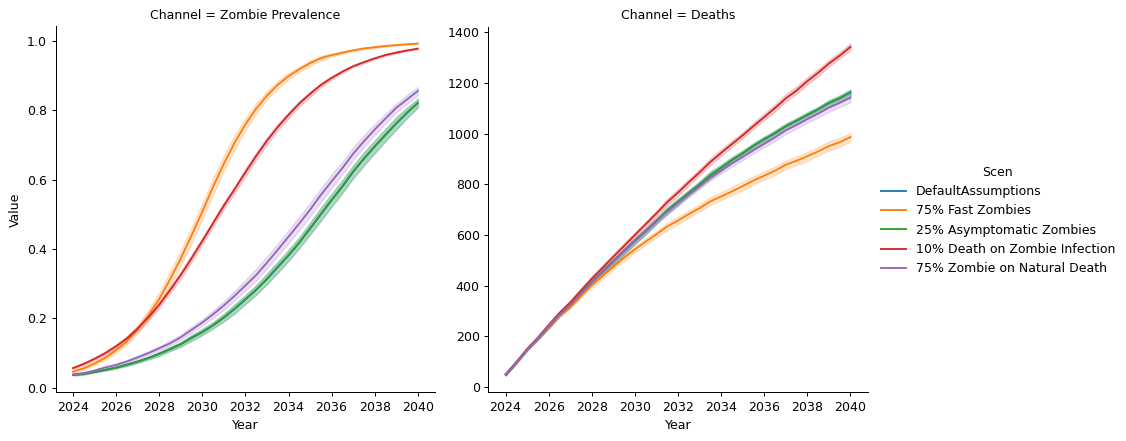

In [61]:
dfm = df.melt(id_vars=['Scen', 'Year', 'rand_seed'], value_vars=['Zombie Prevalence', 'Deaths'], var_name='Channel', value_name='Value')
display(dfm.head())
g = sns.relplot(kind='line', data=dfm, col='Channel', x='Year', y='Value', hue='Scen', facet_kws=dict(sharey=False))

In [65]:
# Create a vaccine intervention
antizombie_vx = zombie_vaccine(efficacy = 0.7)
vx_intv = ss.campaign_vx(
    product = antizombie_vx,
    years = [2028],  # Begin year
    prob = [0.6],    # Coverage
)

# Revise scenarios to see impact of the vaccine
scens_vx = {}
for skey, scen in scens.items():
    scens_vx[skey] = scen.copy()
    scens_vx[skey]['intvs'] = [vx_intv]

In [66]:
results = []
cfgs = []

for skey, scen in scens_vx.items():
    for rand_seed in range(n_repeats):
        cfgs.append({'scen': skey,'rand_seed':rand_seed} | scen) # Merge dicts with pipe operators

T = sc.tic()
results += sc.parallelize(run_zombies, iterkwargs=cfgs)
print(f'That took: {sc.toc(T, output=True):.1f}s')
df_vx = pd.concat(results)

# Combine results
df['Vx'] = False
df_vx['Vx'] = True
df_all = pd.concat([df, df_vx])

That took: 5.3s


/Users/dklein/miniconda3/envs/IDM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dklein/miniconda3/envs/IDM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dklein/miniconda3/envs/IDM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dklein/miniconda3/envs/IDM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

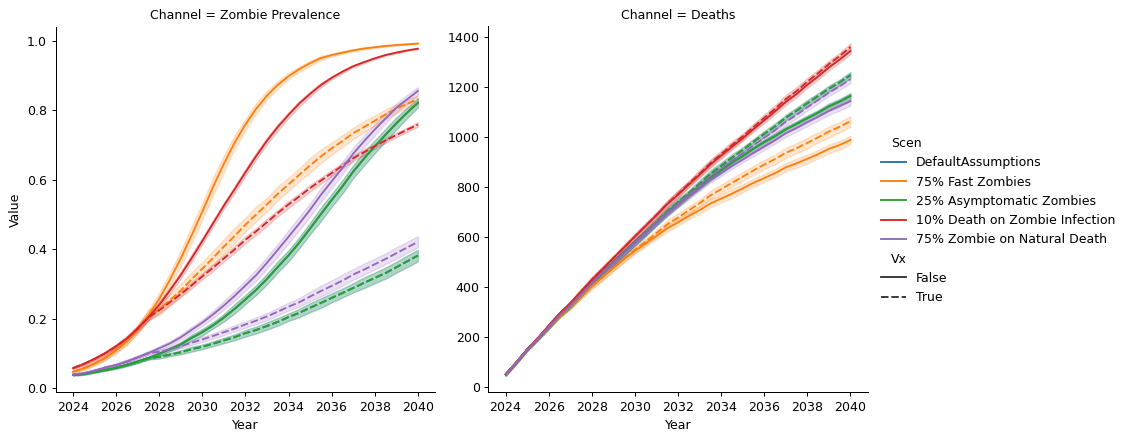

In [67]:
dfm = df_all.melt(id_vars=['Scen', 'Vx', 'Year', 'rand_seed'], value_vars=['Zombie Prevalence', 'Deaths'], var_name='Channel', value_name='Value')
g = sns.relplot(kind='line', data=dfm, col='Channel', x='Year', y='Value', hue='Scen', style='Vx', facet_kws=dict(sharey=False));